In [1]:
import time
import os
import shutil
import sys
import h5py
import tensorflow                             as tf
import numpy                                  as np
import seaborn                                as sns
import pandas                                 as pd
import numpy.random                           as random
from sklearn.utils                        import shuffle
from sklearn.model_selection              import train_test_split
from tqdm                                 import tqdm
from os                                   import path
import pysftp                                 as sftp
import random                                 as rnd

LocalFlg         = 'False'
if (not LocalFlg):
    WORKSPACE_PATH = "/home/venturi/WORKSPACE/"
    IP             = '128.174.245.172'
    User           = "venturi"
else:
    WORKSPACE_PATH = os.getenv('WORKSPACE_PATH')  
    
import matplotlib as mpl
import matplotlib.pyplot                      as plt
plt.style.use(WORKSPACE_PATH+'/SurQCT/surqct/scripts/postprocessing/presentation.mplstyle')

print("="*50)
print(" TensorFlow version: {}".format(tf.__version__))
print(" Eager execution: {}".format(tf.executing_eagerly()))

 TensorFlow version: 2.4.1
 Eager execution: True


In [2]:
WORKSPACE_PATH      = os.environ['WORKSPACE_PATH']
SurQCTFldr      = WORKSPACE_PATH + '/SurQCT/surqct/'

RatesType           = 'KExcit'
ExcitType           = 'KInel'
NNRunIdx            = 8
# ExcitType           = 'KExch'
# NNRunIdx            = 4

# PathToRunFld        = WORKSPACE_PATH + '/SurQCT_MAITH/' + RatesType + '/all_temperatures_nondim/' + ExcitType + '/' 
PathToRunFld        = SurQCTFldr + '/../' + RatesType + '_N3_TransLearn/all_temperatures_nondim/' + ExcitType + '/' 


TTran               = 10000.0

MinRate             = 1.e-15
CPlotFlf            = False

iIdxVec             = np.array([1, 10, 34, 35, 81, 82, 98, 1000, 2000, 3000, 7432, 8000, 9000], dtype=int)
# iIdxVec             = np.array([2500,2600,2700,3000,2090], dtype=int)

In [3]:
#===================================================================================================================================
print("\n[SurQCT]: Loading Modules and Functions ...")

sys.path.insert(0, SurQCTFldr  + '/src/Reading/')
from Reading  import read_levelsdata, read_diatdata

InputFld = PathToRunFld + '/Run_' + str(NNRunIdx) + '/'
print(InputFld)
sys.path.insert(0, InputFld)
#===================================================================================================================================


[SurQCT]: Loading Modules and Functions ...
/home/venturi/WORKSPACE//SurQCT/surqct//../KExcit_N3_TransLearn/all_temperatures_nondim/KInel//Run_8/


In [4]:
#===================================================================================================================================
print("\n[SurQCT]: Keep Loading Modules and Functions...")
from SurQCT_Input import inputdata

print("\n[SurQCT]: Initializing Input ...")
InputData    = inputdata(WORKSPACE_PATH, SurQCTFldr)

Prefix                    = 'Run_'
InputData.NNRunIdx        = NNRunIdx
InputData.PathToRunFld    = InputData.PathToRunFld+'/'+Prefix+str(InputData.NNRunIdx)
InputData.PathToFigFld    = InputData.PathToRunFld+'/'+InputData.PathToFigFld
InputData.PathToParamsFld = InputData.PathToRunFld+'/'+InputData.PathToParamsFld
InputData.PathToDataFld   = InputData.PathToRunFld+'/Data/'                                                               
InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/' 

# InputData.PathToHDF5File  = InputData.WORKSPACE_PATH  + '/Air_Database/HDF5_Database/N3_NASA.hdf5'
# InputData.Molecules       = ['N2','N2'] 
# InputData.PathToLevelsFile= [InputData.WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_LeRoy_log_nd.csv',
#                              InputData.WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_LeRoy_log_nd.csv']
# InputData.PathToDiatFile  = [InputData.WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp',
#                              InputData.WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp']   

#InputData.PathToGrouping  = self.WORKSPACE_PATH  + '/Air_Database/Run_0D/database/grouping/O3_UMN/O2/LevelsMap_DPM45.csv'   
# #===================================================================================================================================


[SurQCT]: Keep Loading Modules and Functions...

[SurQCT]: Initializing Input ...


In [5]:
#===================================================================================================================================
print("\n[SurQCT]: Loading Final Modules ... ")

sys.path.insert(0, SurQCTFldr  + '/src/Model/' + InputData.ApproxModel + '/')
from Model import model


InputData.DefineModelIntFlg  = 1
InputData.TrainIntFlg        = 0
InputData.TransferFlg        = True
NN_KExcit                    = model(InputData, InputData.PathToRunFld, None, None)
NN_KExcit.load_params(InputData.PathToParamsFld)
#===================================================================================================================================


[SurQCT]: Loading Final Modules ... 
[SurQCT]:   Variables Selected for Training:
[SurQCT]:     x =  ['log_EVib_i', 'log_ERot_i', 'ri_i', 'log_rorMin_i', 'TTran_i', 'log_EVib_Delta', 'log_ERot_Delta', 'ri_Delta', 'log_rorMin_Delta', 'TTran_Delta']
[SurQCT]:     y =  KExcit
[SurQCT]:   Defining ML Model from Scratch
[SurQCT]:   Compiling ML Model with Loss and Optimizer
[SurQCT]:   Saving ML Model in File: /home/venturi/WORKSPACE//SurQCT/surqct//../KExcit_N3_TransLearn/all_temperatures_nondim/KInel//Run_8/MyModel
INFO:tensorflow:Assets written to: /home/venturi/WORKSPACE//SurQCT/surqct//../KExcit_N3_TransLearn/all_temperatures_nondim/KInel//Run_8/MyModel/assets
[SurQCT]:   Summarizing ML Model Structure:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                   

In [6]:
#===================================================================================================================================
OtherVar           = InputData.OtherVar
xVarsVec_i         = InputData.xVarsVec_i + ['vqn','jqn']
#xVarsVec_i         = InputData.xVarsVec_i + ['vqn']
xVarsVec_Delta     = InputData.xVarsVec_Delta
xVarsVec           = list(set(xVarsVec_i) | set(xVarsVec_Delta))
print('[SurQCT]:   Reading Variables: ', xVarsVec)

InputData.MultFact = 1.e+9
MinValueTrain      = 1.e-16 * InputData.MultFact
MinValueTest       = 1.e-16 * InputData.MultFact
NoiseSD            = 1.e-13 * InputData.MultFact

NMolecules         = len(InputData.PathToLevelsFile)

InputData.iLevelsVecTest = list(np.array(InputData.iLevelsVecTest) - 1)

[SurQCT]:   Reading Variables:  ['vqn', 'log_ERot', 'log_EVib', 'ri', 'log_rorMin', 'jqn']


In [7]:
#===================================================================================================================================
### Reading Levels Info of Initial and Final Molecules
LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(InputData.PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(InputData.PathToDiatFile[iMol], InputData.Molecules[iMol], np.array([TTran]), np.array([TTran]))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)

[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/N2_LeRoy_log_nd.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/N2_LeRoy_log_nd.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp


In [8]:
#=======================================================================================================================================
# Reading Excitation Rates Data 
def read_kexcitdata(InputData, PathToHDF5File, TTra, TInt, NProcTypes):
    print('[SurQCT]:       Reading HDF5 File from: ' + PathToHDF5File + ' for Excitation Rates at Temperature ' + str(int(TTra)) + 'K')

    HDF5Exist_Flg = path.exists(PathToHDF5File)
    if (HDF5Exist_Flg):
        f = h5py.File(PathToHDF5File, 'a')
    else:
        f = {'key': 'value'}

    TStr = 'T_' + str(int(TTra)) + '_' + str(int(TInt)) + '/Rates/'
    grp  = f[TStr]

    Data  = grp["Inel"]
    KInel = Data[...]

    KOther = []
    for iProc in range(2, NProcTypes):
        ExchStr    = "Exch_" + str(iProc-1)
        Data       = grp[ExchStr] 
        KOtherTemp = Data[...]
        KOther.append(KOtherTemp)

    f.close()   


    return KInel, KOther
#=======================================================================================================================================

In [9]:
KInelMat, KExchMatList = read_kexcitdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)

if (ExcitType == 'KInel'):
    KExcit = KInelMat
elif (ExcitType == 'KExch'):
    KExcit = KExchMatList[0]
else:
    KExcit = KInelMat + KExchMatList[0]

[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database_semiClassicalApprox/N3_NASA.hdf5 for Excitation Rates at Temperature 10000K


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:   0%|          | 0/13 [00:00<?, ?it/s]

Level: 0; vqn: 0; jqn:0


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:   8%|▊         | 1/13 [00:00<00:10,  1.19it/s]

Level: 9; vqn: 0; jqn:9


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:  15%|█▌        | 2/13 [00:01<00:08,  1.35it/s]

Level: 33; vqn: 0; jqn:33


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:  23%|██▎       | 3/13 [00:02<00:07,  1.41it/s]

Level: 34; vqn: 1; jqn:0


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:  31%|███       | 4/13 [00:02<00:06,  1.47it/s]

Level: 80; vqn: 0; jqn:47


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:  38%|███▊      | 5/13 [00:03<00:05,  1.49it/s]

Level: 81; vqn: 1; jqn:33


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:  46%|████▌     | 6/13 [00:04<00:04,  1.52it/s]

Level: 97; vqn: 2; jqn:11


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:  54%|█████▍    | 7/13 [00:04<00:03,  1.51it/s]

Level: 999; vqn: 12; jqn:8


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:  62%|██████▏   | 8/13 [00:05<00:03,  1.52it/s]

Level: 1999; vqn: 1; jqn:143


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:  69%|██████▉   | 9/13 [00:06<00:02,  1.52it/s]

Level: 2999; vqn: 26; jqn:14


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:  77%|███████▋  | 10/13 [00:06<00:01,  1.54it/s]

Level: 7431; vqn: 60; jqn:3


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:  85%|████████▍ | 11/13 [00:07<00:01,  1.58it/s]

Level: 7999; vqn: 26; jqn:150


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices:  92%|█████████▏| 12/13 [00:08<00:00,  1.51it/s]

Level: 8999; vqn: 14; jqn:212


[SurQCT]:     Generating Inelastic and Exchange Rate Matrices: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


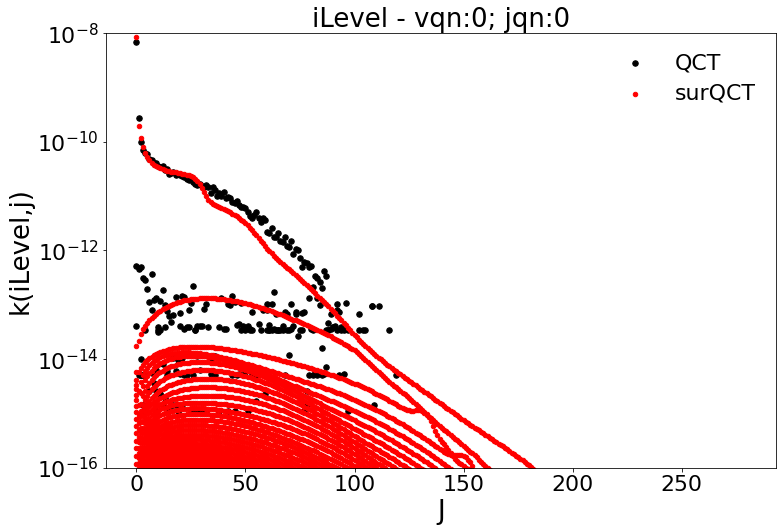

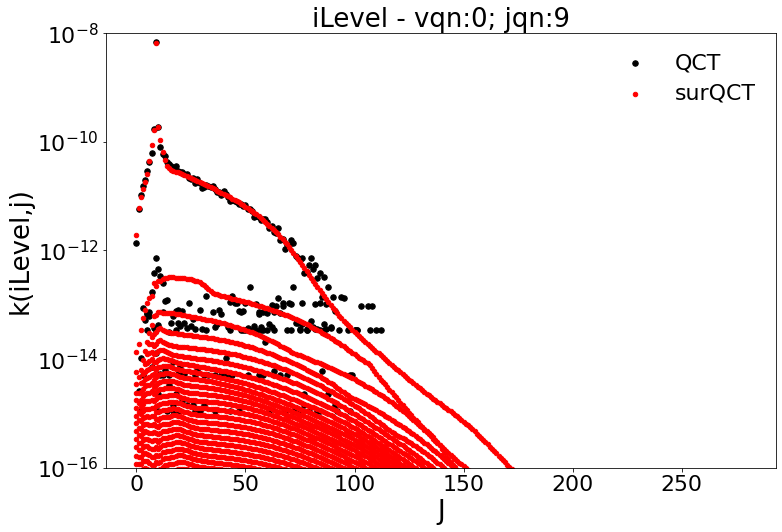

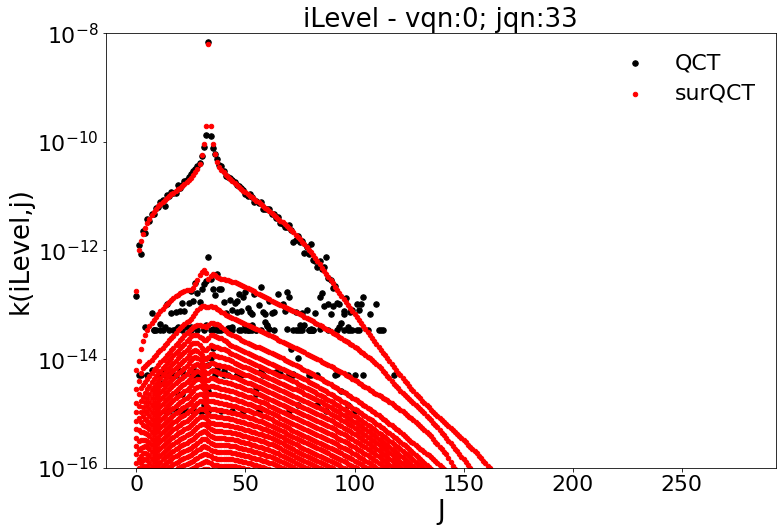

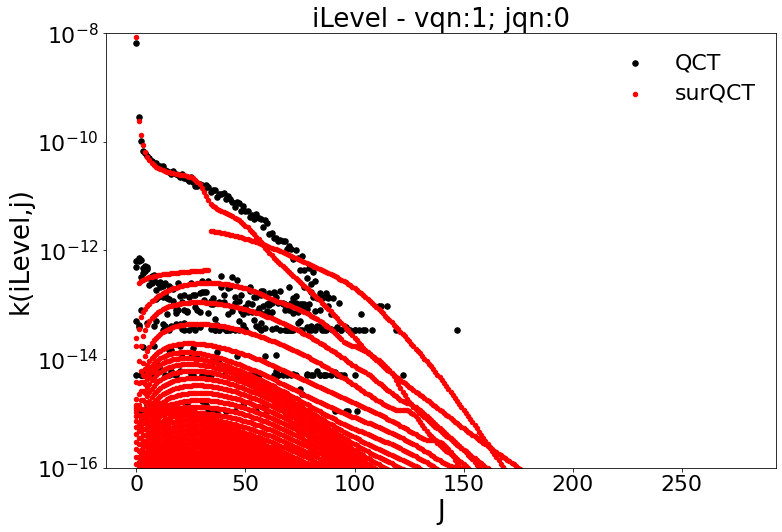

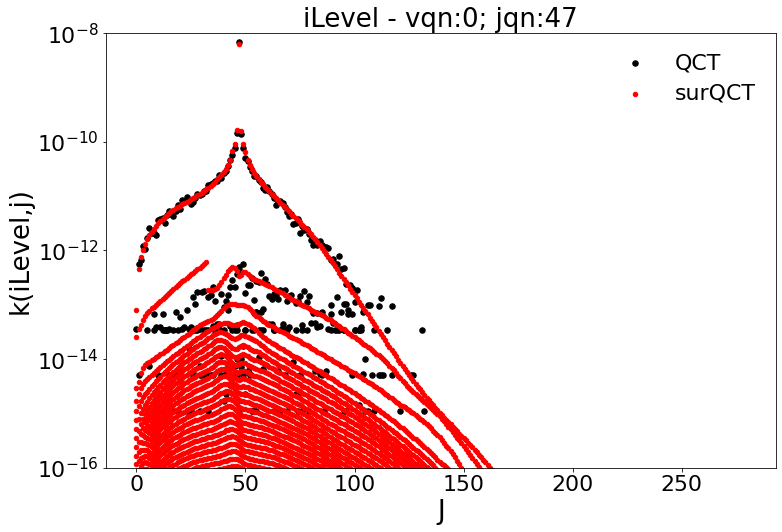

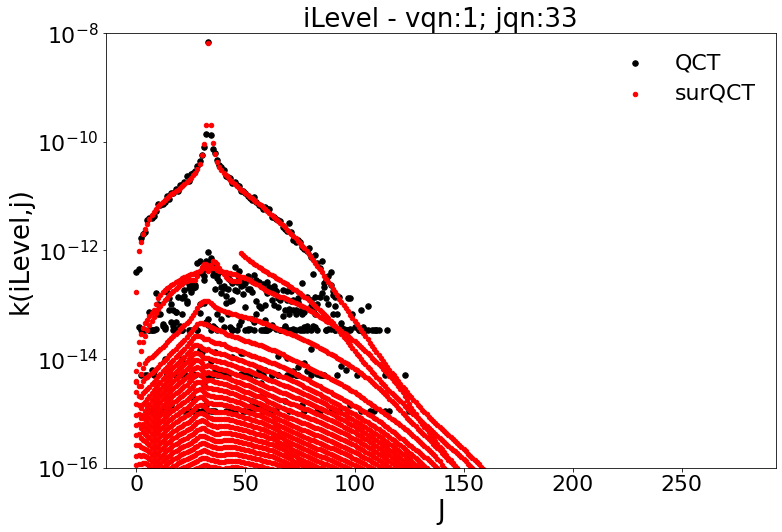

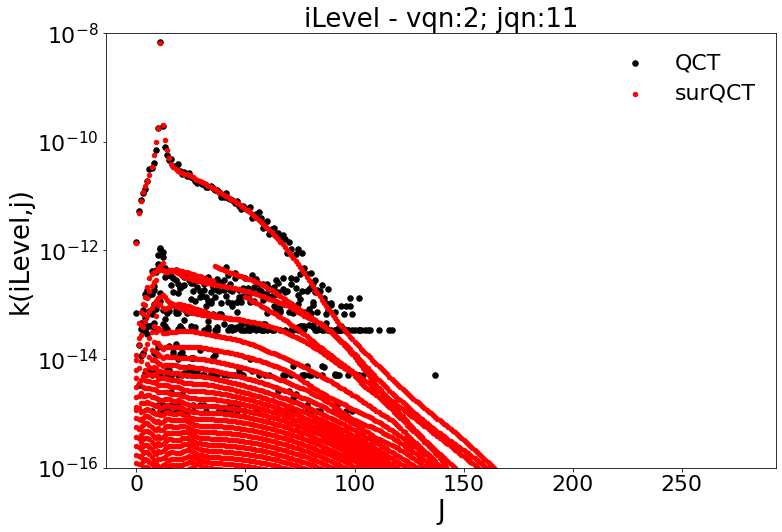

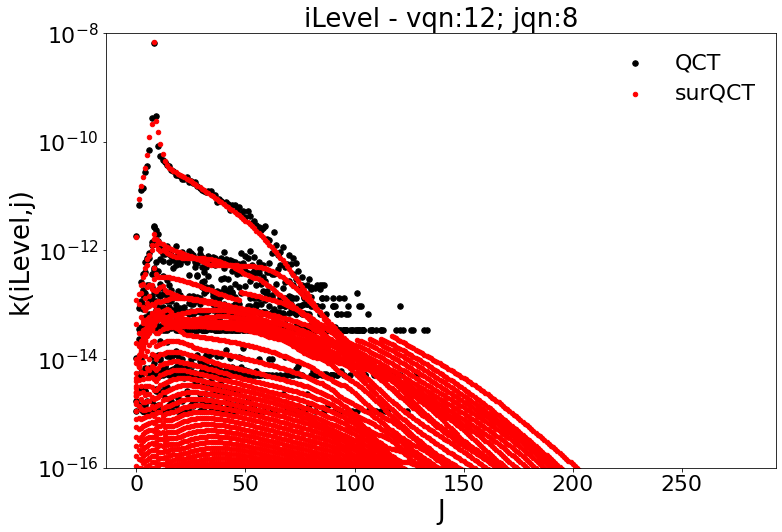

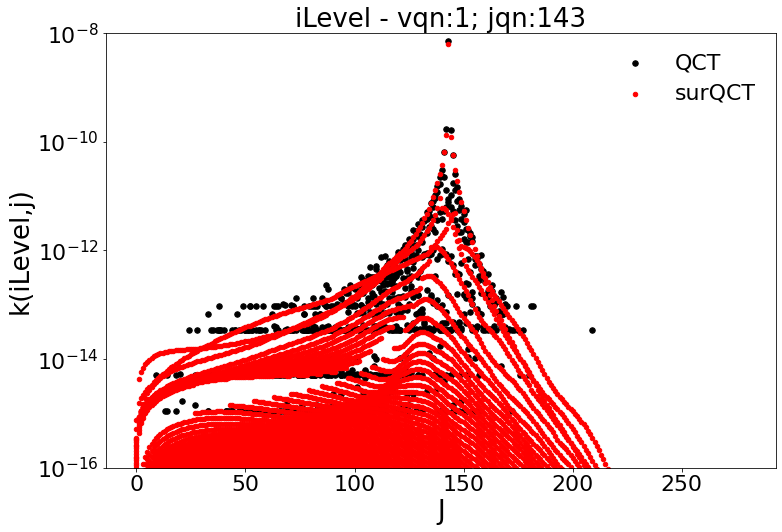

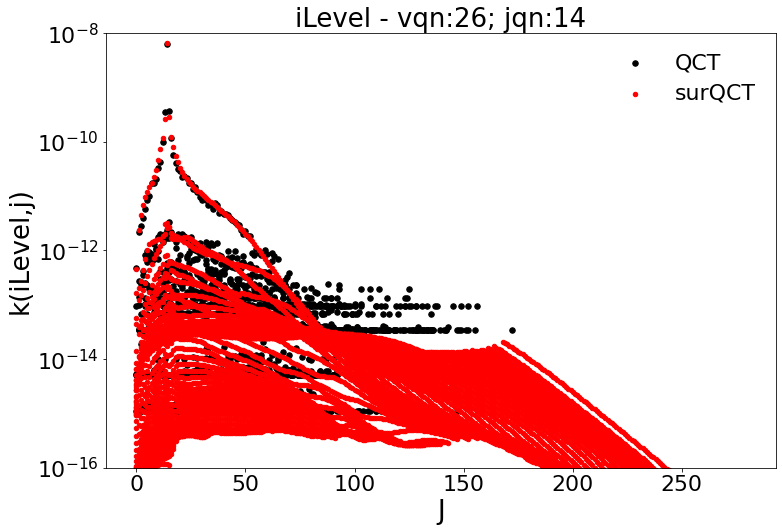

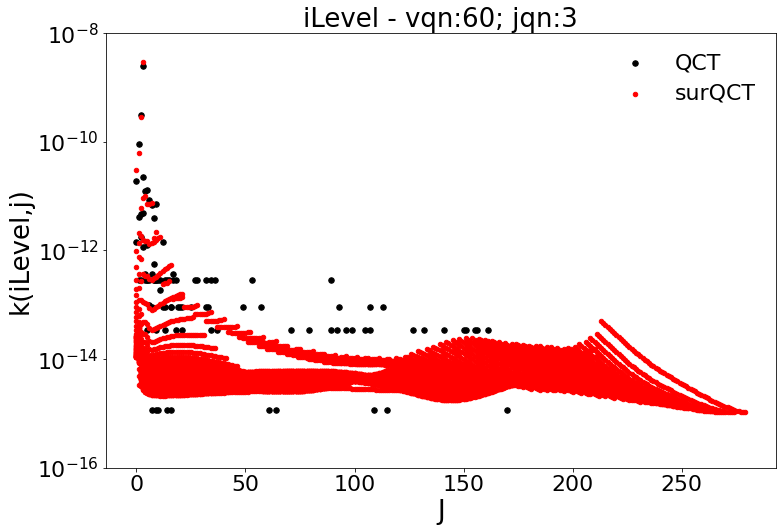

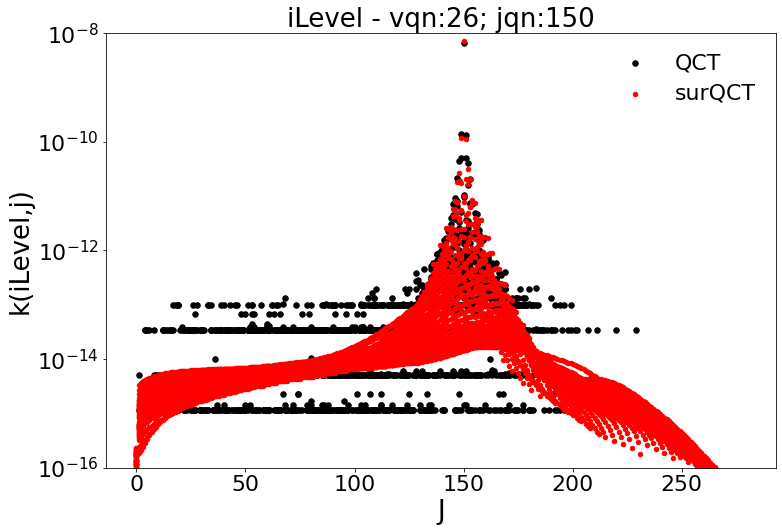

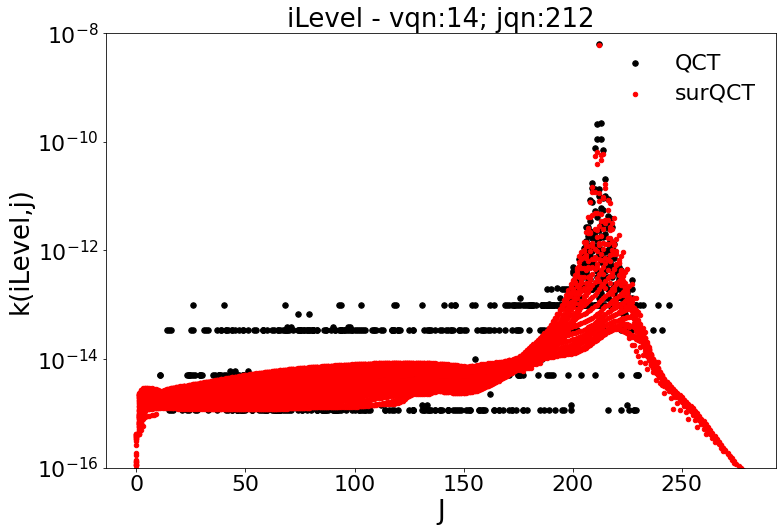

In [10]:
### Loop on Initial States
Str = 'q_'+str(int(TTran))
for iIdx in tqdm(iIdxVec, desc='[SurQCT]:     Generating Inelastic and Exchange Rate Matrices'):

    iIdx -= 1  # Index in python starts from 0
    
    print('Level: '+str(iIdx)+'; vqn: '+str(DiatData[0]['vqn'].to_numpy()[iIdx])+'; jqn:'+str(DiatData[0]['jqn'].to_numpy()[iIdx]))
    time.sleep(0.02)
    
    if (InputData.ExoEndoFlg):
        jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] <= DiatData[0]['EInt'].to_numpy()[iIdx])]
        jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
        RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
    else:
        jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    >= DiatData[0][Str].to_numpy()[iIdx])]
        jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
        RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
    jNLevels              = len(jIdxVec)
    jNLevelsNo            = len(jIdxVecNo)
    
    
    ### FWD Rates
    iiIdxVec              = [iIdx]*jNLevels
    
    TTranVec              = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVec})
    TTranDataTemp.index   = jIdxVec

    
    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = jIdxVec

    jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
    if (OtherVar == '_Delta'):
        jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
    else:
        jLevelsDataTemp   = jLevelsDataTemp
    jLevelsDataTemp.index = jIdxVec
    
    kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
    kLevelsDataTemp.index = jIdxVec

    
    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]
    
    jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
    jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

    kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]
    
    xTemp_FWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)
    
    if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
        KExcit_NN_FWD          = np.exp( NN_KExcit.Model.predict(xTemp_FWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact
    
    
    
    ## BWD Rates
    iiIdxVec              = jIdxVecNo
    jIdxVec               = [iIdx]*jNLevelsNo
    
    TTranVec              = np.ones((jNLevelsNo))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVec})
    TTranDataTemp.index   = iiIdxVec

    
    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy() 
    jLevelsDataTemp.index = iiIdxVec
    if (OtherVar == '_Delta'):
        jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
    else:
        jLevelsDataTemp   = jLevelsDataTemp
    
    kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
    kLevelsDataTemp.index = iiIdxVec

    
    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]
    
    jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
    jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

    kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]
    
    xTempp_BWD            = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)
    
    if (len(xTempp_BWD[NN_KExcit.xTrainingVar]) > 0):
        KExcit_NN_BWD          = np.exp( NN_KExcit.Model.predict(xTempp_BWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact
        KExcit_NN_BWD[:,0]     = KExcit_NN_BWD[:,0] / RatioNo


        iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        iLevelsData.columns   = [(VarName + '_j') for VarName in iLevelsData.columns]

        jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
        jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

        kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        kLevelsData.columns   = [(VarName + '_i') for VarName in kLevelsData.columns]

        xTemp_BWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)


        
    ### Concatenating
        if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
            xTemp     = pd.concat([xTemp_FWD, xTemp_BWD], axis=0)
            KExcit_NN = np.concatenate((KExcit_NN_FWD, KExcit_NN_BWD), axis=0)
        else:
            xTemp     = xTemp_BWD
            KExcit_NN = KExcit_NN_BWD
    else:
        if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
            xTemp     = xTemp_FWD
            KExcit_NN = KExcit_NN_FWD
    
    
    ### Plotting
    Mask     = KExcit[iIdx,:] > MinRate
    
    if (CPlotFlf):
    
        vmax     = -8
        vmin     = -14

        cdict = {
          'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
          'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
          'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
        }

        fig, axs = plt.subplots(1,2,figsize=(15,15))

        axs[0].scatter(DiatData[1]['vqn'][Mask], DiatData[1]['jqn'][Mask], c=np.log10(KExcit[iIdx,Mask]), vmin=vmin, vmax=vmax)
        axs[0].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[0].set_ylim([DiatData[1]['jqn'].min(), DiatData[1]['jqn'].max()])

        axs[1].scatter(xTemp['vqn_j'], xTemp['jqn_j'], c=np.log10(KExcit_NN[:,0]), vmin=vmin, vmax=vmax)
        axs[1].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[1].set_ylim([DiatData[1]['jqn'].min(), DiatData[1]['jqn'].max()])

        ax=plt.gca()
        PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
        #plt.colorbar(PCM, ax=ax) 
        
    else:
        
        j_color = xTemp['jqn_j'] % 2
        cmap=mpl.colors.ListedColormap(["navy","crimson","limegreen","gold","k","r","b","y","c"])
        cmap1=mpl.colors.ListedColormap(["gold","r"])
        fig = plt.figure(figsize=(12,8))
        
        label_plot = "iLevel - vqn:" + str(DiatData[0]['vqn'].to_numpy()[iIdx])+"; jqn:"+str(DiatData[0]['jqn'].to_numpy()[iIdx])
        plt.scatter(DiatData[1]['jqn'][Mask], KExcit[iIdx,Mask], c='k', s=30,label='QCT')
#         plt.scatter(xTemp['jqn_j'], KExcit_NN[:,0], s=20, c='r', label='surQCT')
        plt.scatter(xTemp['jqn_j'], KExcit_NN[:,0], s=20, c='r', label='surQCT')
        plt.yscale('log')
        plt.legend(['QCT','surQCT'],frameon=False)
        plt.ylim([1.e-16, 1.e-8])
        plt.xlabel('J')
        plt.ylabel('k(iLevel,j)')
        plt.title(label_plot)

In [11]:
### Loop on Initial States
Str = 'q_'+str(int(TTran))
for iIdx in tqdm(iIdxVec, desc='[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes'):

    iIdx -= 1  # Index in python starts from 0
    
    print('Level: '+str(iIdx)+'; vqn: '+str(DiatData[0]['vqn'].to_numpy()[iIdx])+'; jqn:'+str(DiatData[0]['jqn'].to_numpy()[iIdx]))
    time.sleep(0.02)
    
    if (InputData.ExoEndoFlg):
        jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] <= DiatData[0]['EInt'].to_numpy()[iIdx])]
        jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
        RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
    else:
        jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    >= DiatData[0][Str].to_numpy()[iIdx])]
        jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
        RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
    jNLevels              = len(jIdxVec)
    jNLevelsNo            = len(jIdxVecNo)
    
    
    ### FWD Rates
    iiIdxVec              = [iIdx]*jNLevels
    
    TTranVec              = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVec})
    TTranDataTemp.index   = jIdxVec

    
    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = jIdxVec

    jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
    if (OtherVar == '_Delta'):
        jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
    else:
        jLevelsDataTemp   = jLevelsDataTemp
    jLevelsDataTemp.index = jIdxVec
    
    kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
    kLevelsDataTemp.index = jIdxVec

    
    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]
    
    jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
    jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

    kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]
    
    xTemp_FWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)
    
    if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
        KExcit_NN_FWD          = np.exp( NN_KExcit.Model.predict(xTemp_FWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact
    
    
    
    ## BWD Rates
    iiIdxVec              = jIdxVecNo
    jIdxVec               = [iIdx]*jNLevelsNo
    
    TTranVec              = np.ones((jNLevelsNo))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVec})
    TTranDataTemp.index   = iiIdxVec

    
    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy() 
    jLevelsDataTemp.index = iiIdxVec
    if (OtherVar == '_Delta'):
        jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
    else:
        jLevelsDataTemp   = jLevelsDataTemp
    
    kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
    kLevelsDataTemp.index = iiIdxVec

    
    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]
    
    jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
    jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

    kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]
    
    xTempp_BWD            = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)
    
    if (len(xTempp_BWD[NN_KExcit.xTrainingVar]) > 0):
        KExcit_NN_BWD          = np.exp( NN_KExcit.Model.predict(xTempp_BWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact
        KExcit_NN_BWD[:,0]     = KExcit_NN_BWD[:,0] / RatioNo


        iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        iLevelsData.columns   = [(VarName + '_j') for VarName in iLevelsData.columns]

        jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
        jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

        kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        kLevelsData.columns   = [(VarName + '_i') for VarName in kLevelsData.columns]

        xTemp_BWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)


        
    ### Concatenating
        if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
            xTemp     = pd.concat([xTemp_FWD, xTemp_BWD], axis=0)
            KExcit_NN = np.concatenate((KExcit_NN_FWD, KExcit_NN_BWD), axis=0)
        else:
            xTemp     = xTemp_BWD
            KExcit_NN = KExcit_NN_BWD
    else:
        if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
            xTemp     = xTemp_FWD
            KExcit_NN = KExcit_NN_FWD
      
    
    if (InputData.Molecules[0] == 'N2'):
        MaskRuleYES = np.mod(jqnVec[iIdx],2) == np.mod(jqnVec,2)
        MaskRuleNO  = np.mod(jqnVec[iIdx],2) != np.mod(jqnVec,2)
        if (np.mod(jqnVec[iIdx],2) == 0):
            KExcit_NN[OddToEvenP[MaskRuleNO]] += KExcit_NN[MaskRuleNO]/2.
            KExcit_NN[OddToEvenM[MaskRuleNO]] += KExcit_NN[MaskRuleNO]/2.
        else:
            KExcit_NN[EvenToOddP[MaskRuleNO]] += KExcit_NN[MaskRuleNO]/2.
            KExcit_NN[EvenToOddM[MaskRuleNO]] += KExcit_NN[MaskRuleNO]/2.        
        KExcit_NN[MaskRuleNO] = 0.
    
    
    ### Plotting
    Mask     = KExcit[iIdx,:] > MinRate
    
    if (CPlotFlf):
    
        vmax     = -8
        vmin     = -14

        cdict = {
          'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
          'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
          'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
        }

        fig, axs = plt.subplots(1,2,figsize=(15,15))

        axs[0].scatter(DiatData[1]['vqn'][Mask], DiatData[1]['jqn'][Mask], c=np.log10(KExcit[iIdx,Mask]), vmin=vmin, vmax=vmax)
        axs[0].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[0].set_ylim([DiatData[1]['jqn'].min(), DiatData[1]['jqn'].max()])

        axs[1].scatter(xTemp['vqn_j'], xTemp['jqn_j'], c=np.log10(KExcit_NN[:,0]), vmin=vmin, vmax=vmax)
        axs[1].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[1].set_ylim([DiatData[1]['jqn'].min(), DiatData[1]['jqn'].max()])

        ax=plt.gca()
        PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
        #plt.colorbar(PCM, ax=ax) 
        
    else:
        
        j_color = xTemp['jqn_j'] % 2
        cmap=mpl.colors.ListedColormap(["navy","crimson","limegreen","gold","k","r","b","y","c"])
        cmap1=mpl.colors.ListedColormap(["gold","r"])
        fig = plt.figure(figsize=(12,8))

        plt.scatter(DiatData[1]['jqn'][Mask], KExcit[iIdx,Mask], s=30)
        plt.scatter(xTemp['jqn_j'], KExcit_NN[:,0], s=10, c=(j_color), cmap=cmap1)
        plt.yscale('log')
        plt.ylim([1.e-16, 1.e-8])

[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:   0%|          | 0/13 [00:00<?, ?it/s]

Level: 0; vqn: 0; jqn:0


[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes:   0%|          | 0/13 [00:00<?, ?it/s]


NameError: name 'jqnVec' is not defined

In [ ]:
KInelMat, KExchMatList = read_kexcitdata(InputData, InputData.PathToHAHDF5File, TTran, TTran, 3)

if (ExcitType == 'KInel'):
    KExcit = KInelMat
elif (ExcitType == 'KExch'):
    KExcit = KExchMatList[0]
else:
    KExcit = KInelMat + KExchMatList[0]

# plt.figure(figsize=(20,20))
# plt.imshow(np.log10(KExcit))

# plt.figure(figsize=(20,10))
# plt.plot(KExcit[937,:],'o')
# plt.yscale('log')

In [ ]:
NIdx    = 10

iIdxVec = np.squeeze(pd.read_csv(InputData.PathToSampledLevels+str(int(TTran))+'K.csv').to_numpy(int))

In [ ]:
### Loop on Initial States
Str = 'q_'+str(int(TTran))
for iIdx in tqdm(rnd.choices(list(iIdxVec), k=NIdx), desc='[SurQCT]:     Generating Inelastic and Exchange Rate Matrixes'):
    print('iLevel = ', iIdx)
    iIdx -= 1
    time.sleep(0.02)
    
    if (InputData.ExoEndoFlg):
        jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] <= DiatData[0]['EInt'].to_numpy()[iIdx])]
        jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
        RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1]['EInt'].to_numpy()[jIdx] > DiatData[0]['EInt'].to_numpy()[iIdx])]
    else:
        jIdxVec           = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    >= DiatData[0][Str].to_numpy()[iIdx])]
        jIdxVecNo         = [jIdx for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
        RatioNo           = [DiatData[0][Str].to_numpy()[iIdx]/DiatData[1][Str].to_numpy()[jIdx] for jIdx in np.arange(NLevels[1]) if (DiatData[1][Str].to_numpy()[jIdx]    < DiatData[0][Str].to_numpy()[iIdx])]
    jNLevels              = len(jIdxVec)
    jNLevelsNo            = len(jIdxVecNo)
    
    
    
    ### FWD Rates
    iiIdxVec              = [iIdx]*jNLevels
    
    TTranVec              = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVec})
    TTranDataTemp.index   = jIdxVec

    
    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = jIdxVec

    jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
    if (OtherVar == '_Delta'):
        jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
    else:
        jLevelsDataTemp   = jLevelsDataTemp
    jLevelsDataTemp.index = jIdxVec
    
    kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
    kLevelsDataTemp.index = jIdxVec

    
    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]
    
    jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
    jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

    kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]
    
    xTemp_FWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)
    
    if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
        KExcit_NN_FWD          = np.exp( NN_KExcit.Model.predict(xTemp_FWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact
    
    
    
    ## BWD Rates
    iiIdxVec              = jIdxVecNo
    jIdxVec               = [iIdx]*jNLevelsNo
    
    TTranVec              = np.ones((jNLevelsNo))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVec})
    TTranDataTemp.index   = iiIdxVec

    
    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    jLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy() 
    jLevelsDataTemp.index = iiIdxVec
    if (OtherVar == '_Delta'):
        jLevelsDataTemp   = iLevelsDataTemp.subtract(jLevelsDataTemp) 
    else:
        jLevelsDataTemp   = jLevelsDataTemp
    
    kLevelsDataTemp       = LevelsData[1].iloc[jIdxVec,:].copy()        
    kLevelsDataTemp.index = iiIdxVec

    
    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]
    
    jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
    jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

    kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    kLevelsData.columns   = [(VarName + '_j') for VarName in kLevelsData.columns]
    
    xTempp_BWD            = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)

    if (len(xTempp_BWD[NN_KExcit.xTrainingVar]) > 0):# and (False):
        KExcit_NN_BWD          = np.exp( NN_KExcit.Model.predict(xTempp_BWD[NN_KExcit.xTrainingVar]) ) / InputData.MultFact
        KExcit_NN_BWD[:,0]     = KExcit_NN_BWD[:,0] / RatioNo


        iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        iLevelsData.columns   = [(VarName + '_j') for VarName in iLevelsData.columns]

        jLevelsData           = pd.concat([jLevelsDataTemp[xVarsVec_Delta], TTranDataTemp], axis=1)
        jLevelsData.columns   = [(VarName + OtherVar) for VarName in jLevelsData.columns]

        kLevelsData           = pd.concat([kLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
        kLevelsData.columns   = [(VarName + '_i') for VarName in kLevelsData.columns]

        xTemp_BWD             = pd.concat([iLevelsData, jLevelsData, kLevelsData], axis=1)


        
    ### Concatenating
        if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
            xTemp     = pd.concat([xTemp_FWD, xTemp_BWD], axis=0)
            KExcit_NN = np.concatenate((KExcit_NN_FWD, KExcit_NN_BWD), axis=0)
        else:
            xTemp     = xTemp_BWD
            KExcit_NN = KExcit_NN_BWD
    else:
        if (len(xTemp_FWD[NN_KExcit.xTrainingVar]) > 0):
            xTemp     = xTemp_FWD
            KExcit_NN = KExcit_NN_FWD
    
    
    if (InputData.Molecules[0] == 'N2'):
        MaskRuleYES = np.mod(jqnVec[iIdx],2) == np.mod(jqnVec,2)
        MaskRuleNO  = np.mod(jqnVec[iIdx],2) != np.mod(jqnVec,2)
        if (np.mod(jqnVec[iIdx],2) == 0):
            KExcit_NN[OddToEvenP[MaskRuleNO]] += KExcit_NN[MaskRuleNO]/2.
            KExcit_NN[OddToEvenM[MaskRuleNO]] += KExcit_NN[MaskRuleNO]/2.
        else:
            KExcit_NN[EvenToOddP[MaskRuleNO]] += KExcit_NN[MaskRuleNO]/2.
            KExcit_NN[EvenToOddM[MaskRuleNO]] += KExcit_NN[MaskRuleNO]/2.
        KExcit_NN[MaskRuleNO] = 0.
    
    
    
    ### Plotting
    Mask     = KExcit[iIdx,:] > MinRate    
    
    if (CPlotFlf):
    
        vmax     = -8
        vmin     = -14

        cdict = {
          'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
          'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
          'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
        }

        fig, axs = plt.subplots(1,2,figsize=(15,15))

        axs[0].scatter(DiatData[1]['vqn'][Mask], DiatData[1]['jqn'][Mask], c=np.log10(KExcit[iIdx,Mask]), vmin=vmin, vmax=vmax)
        axs[0].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[0].set_ylim([DiatData[1]['jqn'].min(), DiatData[1]['jqn'].max()])

        axs[1].scatter(xTemp['vqn_j'], xTemp['jqn_j'], c=np.log10(KExcit_NN[:,0]), vmin=vmin, vmax=vmax)
        axs[1].set_xlim([DiatData[1]['vqn'].min(), DiatData[1]['vqn'].max()])
        axs[1].set_ylim([DiatData[1]['jqn'].min(), DiatData[1]['jqn'].max()])

        ax=plt.gca()
        PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
        #plt.colorbar(PCM, ax=ax) 
        
    else:
        
        fig = plt.figure(figsize=(12,8))

        plt.scatter(DiatData[1]['jqn'][Mask], KExcit[iIdx,Mask], s=20)
        plt.scatter(xTemp['jqn_j'], KExcit_NN[:,0], s=10)
        plt.yscale('log')
        plt.ylim([1.e-16, 1.e-8])

In [ ]:
WORKSPACE_PATH